In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark import SparkConf

sc = SparkContext(master = 'local', appName = 'ecommerce clothing review')

spark = SparkSession(sc)

In [2]:
data = spark.read.csv("womens-ecommerce-clothing-reviews/Womens_Clothing_E_Commerce_Reviews.csv", header = True, inferSchema= True)

In [3]:
data.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- Clothing ID: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Review Text: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Recommended IND: string (nullable = true)
 |-- Positive Feedback Count: string (nullable = true)
 |-- Division Name: string (nullable = true)
 |-- Department Name: string (nullable = true)
 |-- Class Name: string (nullable = true)



In [4]:
data.show(5)

+---+-----------+---+--------------------+--------------------+------+---------------+-----------------------+--------------+---------------+----------+
|_c0|Clothing ID|Age|               Title|         Review Text|Rating|Recommended IND|Positive Feedback Count| Division Name|Department Name|Class Name|
+---+-----------+---+--------------------+--------------------+------+---------------+-----------------------+--------------+---------------+----------+
|  0|        767| 33|                null|Absolutely wonder...|     4|              1|                      0|     Initmates|       Intimate| Intimates|
|  1|       1080| 34|                null|"Love this dress!...|     5|              1|                      4|       General|        Dresses|   Dresses|
|  2|       1077| 60|Some major design...|I had such high h...|     3|              0|                      0|       General|        Dresses|   Dresses|
|  3|       1049| 50|    My favorite buy!|I love, love, lov...|     5|            

In [5]:
data.count()

26928

# Check Null, NaN and duplicates

In [6]:
from pyspark.sql.functions import *
data.select([count(when(isnan(col), col)).alias(col) for col in data.columns]).show()

+---+-----------+---+-----+-----------+------+---------------+-----------------------+-------------+---------------+----------+
|_c0|Clothing ID|Age|Title|Review Text|Rating|Recommended IND|Positive Feedback Count|Division Name|Department Name|Class Name|
+---+-----------+---+-----+-----------+------+---------------+-----------------------+-------------+---------------+----------+
|  0|          0|  0|    0|          0|     0|              0|                      0|            0|              0|         0|
+---+-----------+---+-----+-----------+------+---------------+-----------------------+-------------+---------------+----------+



In [7]:
data.select([count(when(isnull(col), col)).alias(col) for col in data.columns]).show()

+---+-----------+----+-----+-----------+------+---------------+-----------------------+-------------+---------------+----------+
|_c0|Clothing ID| Age|Title|Review Text|Rating|Recommended IND|Positive Feedback Count|Division Name|Department Name|Class Name|
+---+-----------+----+-----+-----------+------+---------------+-----------------------+-------------+---------------+----------+
|  0|        826|1134| 5095|       2214|  3271|           3342|                   4368|         4918|           5221|      5365|
+---+-----------+----+-----+-----------+------+---------------+-----------------------+-------------+---------------+----------+



In [8]:
data.count() - data.distinct().count()

166

# Word Cloud for determining how many times some words were used

In [9]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sb
import re

In [10]:
review_text = data.select('Review Text').toPandas()
review_text.head()

,Review Text
0,Absolutely wonderful - silky and sexy and comf...
1,"""Love this dress! it's sooo pretty. i happen..."
2,I had such high hopes for this dress and reall...
3,"I love, love, love this jumpsuit. it's fun, fl..."
4,This shirt is very flattering to all due to th...


In [11]:
review_text = review_text['Review Text']
type(review_text)

pandas.core.series.Series

In [12]:
words = ""
for val in review_text:
    val = str(val)
    tokens = val.split()
    for ele in range(len(tokens)):
        if re.match("\w+", tokens[ele]):
            tokens[ele] = tokens[ele].lower()
    words += " ".join(tokens) + " "

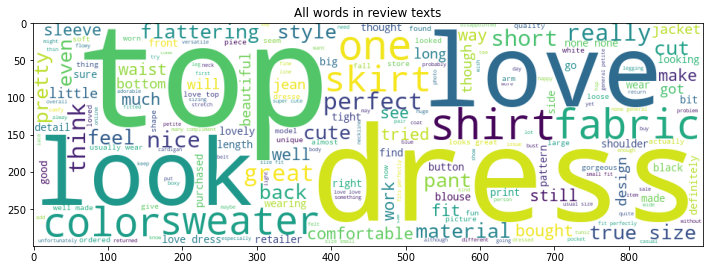

In [13]:
plt.figure(figsize = (12, 15))
wordcloud = WordCloud(background_color='white', width = 900, height = 300, stopwords=set(STOPWORDS)).generate(words)
plt.imshow(wordcloud)
plt.title('All words in review texts')
plt.show()

There are some common words for review texts

# See relations between ratings and other columns

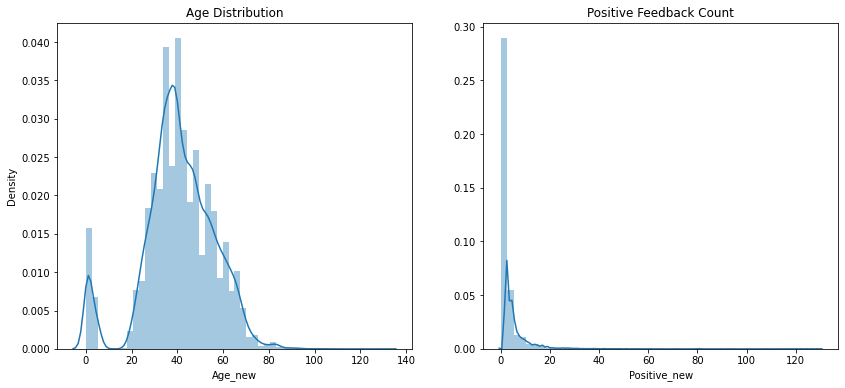

In [14]:
from pyspark.sql.types import DoubleType
age = data.select('Age').dropna()
age_cast = age.withColumn('Age_new', age['Age'].cast(DoubleType())).drop('Age').toPandas()
age_cast = age_cast.dropna()

pos_feed = data.select('Positive Feedback Count').dropna()
pos_cast = pos_feed.withColumn('Positive_new', pos_feed['Positive Feedback Count'].cast(DoubleType())).drop('Positive Feedback Count').toPandas()
pos_cast = pos_cast.dropna()

recommend = data.select('Recommended IND').dropna()
recommend_cast = recommend.withColumn('Recommend_new', recommend['Recommended IND'].cast(DoubleType())).drop('Recommended IND').toPandas()
recommend_cast = recommend_cast.dropna()

f, ax = plt.subplots(1, 2, figsize = (14, 6), sharey = False)
sb.distplot(age_cast['Age_new'], ax = ax[0])
ax[0].set_title("Age Distribution")
ax[0].set_ylabel("Density")

sb.distplot(pos_cast['Positive_new'], ax = ax[1])
ax[1].set_title("Positive Feedback Count")
plt.show()

We can see that most reviewers are ranging from 30 to 60 years old and there are some mistakes when collecting age data that some of them have age closing to 0. So those types charts give us many information that can apply for our next sales campaign.

In [15]:
age_cast.max(axis = 0, skipna = True)

Age_new    130.0
dtype: float64

In [16]:
age_cast.min(axis = 0, skipna = True)

Age_new    0.0
dtype: float64

==> There are some mistakes in age column, so we need to filter age when training model

In [17]:
rating_age = data.select('Rating', 'Age').dropna()
rating_age = rating_age.withColumn('Rating_new', rating_age['Rating'].cast(DoubleType())).drop('Rating').withColumn('Age_new', rating_age['Age'].cast(DoubleType())).drop('Age').toPandas()
rating_age = rating_age.dropna()

In [18]:
rating_age = rating_age[(rating_age['Rating_new'] >= 1 )& (rating_age['Rating_new'] <= 5) & (rating_age['Age_new'] >= 15) & (rating_age['Age_new'] <= 80)]

In [19]:
rating_age

,Rating_new,Age_new
0,4.0,33.0
1,5.0,34.0
2,3.0,60.0
3,5.0,50.0
4,5.0,47.0
5,2.0,49.0
6,5.0,39.0
7,4.0,39.0
8,5.0,24.0
10,3.0,53.0


In [20]:
avg1 = rating_age.groupby('Rating_new').mean()
avg1

,Age_new
Rating_new,
1.0,43.375174
2.0,42.345295
3.0,41.884514
4.0,42.606370
5.0,43.116612


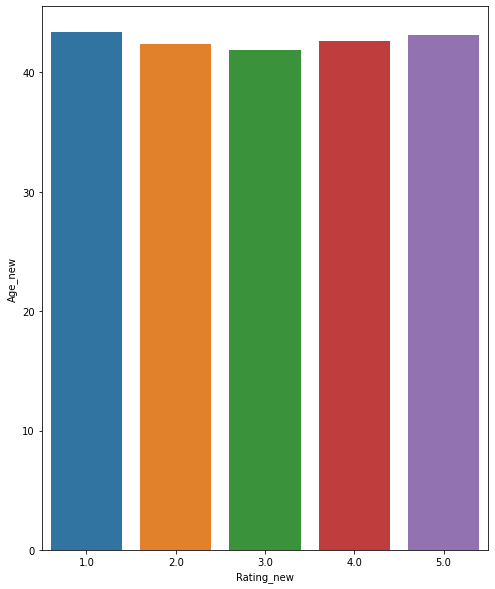

In [21]:
plt.figure(figsize = (8,10))
sb.barplot(x = avg1.index, y = 'Age_new', data = avg1)
plt.show()

==> Ratings seem pretty the same when compare age together, so we do not need Age for training

In [22]:
rating_re = data.select('Rating', 'Recommended IND').dropna()
rating_re = rating_re.withColumn('Rating_new', rating_re['Rating'].cast(DoubleType())).drop('Rating').withColumn('Re_new', rating_re['Recommended IND'].cast(DoubleType())).drop('Recommended IND').toPandas()
rating_re = rating_re.dropna()

In [23]:
rating_re = rating_re[(rating_re['Rating_new'] >= 1 )& (rating_re['Rating_new'] <= 5) & (rating_re['Re_new'] <= 1) & (rating_re['Re_new'] >= 0)]

In [24]:
rating_re

,Rating_new,Re_new
0,4.0,1.0
1,5.0,1.0
2,3.0,0.0
3,5.0,1.0
4,5.0,1.0
5,2.0,0.0
6,5.0,1.0
7,4.0,1.0
8,5.0,1.0
10,3.0,0.0


In [25]:
avg2 = rating_re.groupby('Re_new').mean()
avg2

,Rating_new
Re_new,
0.0,2.277136
1.0,4.609262


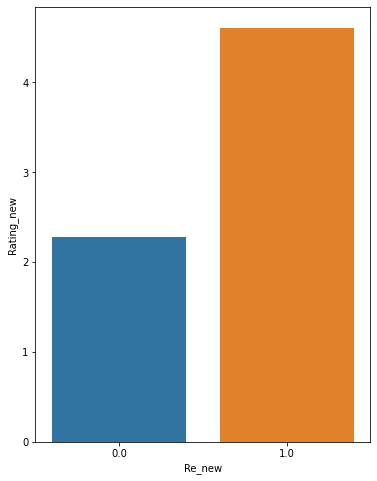

In [26]:
plt.figure(figsize = (6,8))
sb.barplot(x = avg2.index, y = 'Rating_new', data = avg2)
plt.show()

==> We may use Recommneded IND for training data

In [27]:
rating_re = data.select('Rating', 'Positive Feedback Count').dropna()
rating_re = rating_re.withColumn('Rating_new', rating_re['Rating'].cast(DoubleType())).drop('Rating').withColumn('Po_new', rating_re['Positive Feedback Count'].cast(DoubleType())).drop('Positive Feedback Count').toPandas()
rating_re = rating_re.dropna()

In [28]:
rating_re = rating_re[(rating_re['Rating_new'] >= 1 )& (rating_re['Rating_new'] <= 5) & (rating_re['Po_new'] <= 40) & (rating_re['Po_new'] >= 0)]

In [29]:
avg3 = rating_re.groupby('Rating_new').mean()
avg3

,Po_new
Rating_new,
1.0,2.972145
2.0,2.908512
3.0,2.695255
4.0,1.883663
5.0,1.930459


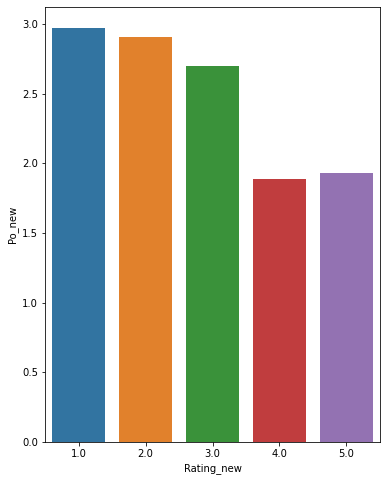

In [30]:
plt.figure(figsize = (6,8))
sb.barplot(x = avg3.index, y = 'Po_new', data = avg3)
plt.show()

==> They are not different a lot between negative and positive rating because the range for number of positive reviews is up to 40

In [31]:
from pyspark.sql.types import StringType
rating_re = data.select('Rating', 'Class Name').dropna()
rating_re = rating_re.withColumn('Rating_new', rating_re['Rating'].cast(DoubleType())).drop('Rating').withColumn('Class_new', rating_re['Class Name'].cast(StringType())).drop('Class Name').toPandas()
rating_re = rating_re.dropna()

In [32]:
rating_re = rating_re[(rating_re['Rating_new'] >= 1 )& (rating_re['Rating_new'] <= 5)]

In [33]:
rating_re.head()

,Rating_new,Class_new
0,4.0,Intimates
1,5.0,Dresses
2,3.0,Dresses
3,5.0,Pants
4,5.0,Blouses


In [34]:
avg4 = rating_re.groupby('Class_new').mean()
avg4

,Rating_new
Class_new,
Blouses,4.170960
Casual bottoms,5.000000
Chemises,4.000000
Dresses,4.148163
Fine gauge,4.265439
Intimates,4.318841
Jackets,4.304647
Jeans,4.379386
Knits,4.162169


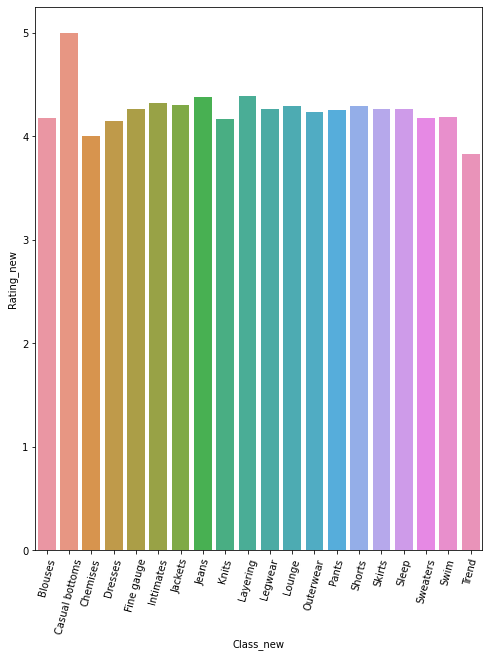

In [35]:
plt.figure(figsize = (8,10))
sb.barplot(x = avg4.index, y = 'Rating_new', data = avg4)
plt.xticks(rotation=75)
plt.show()

==> Types of products do not affect to ratings

There are many missing values for titles, so we do need to use this column or we may apply it after training with 2 features

# Choose Recommended IND and Review Text for training

We need to preprocess data before training model

In [36]:
data_filter = data.select('Review Text', 'Recommended IND', 'Rating')
data_filter.count()

26928

In [37]:
data_filter = data_filter.dropna(how = 'any')
data_filter.count()

22739

In [38]:
data_filter = data_filter.filter((data_filter['Recommended IND'] == 1 ) | (data_filter['Recommended IND'] == 0))
data_filter.count()

18390

In [39]:
data_filter = data_filter.filter((data_filter['Rating'] <= 5 ) | (data_filter['Rating'] >= 1))
data_filter.count()

18371

==> We can detect that we lost so much data here, so we may use only Review Text for training data

In [40]:
data_filter2 = data.select('Review Text', 'Rating')
data_filter2.count()

26928

In [41]:
data_filter2 = data_filter2.dropna(how = 'any')
data_filter2.count()

22812

In [42]:
data_filter2 = data_filter2.filter((data_filter2['Rating'] <= 5 ) | (data_filter2['Rating'] >= 1))
data_filter2.count()

18721

We need to set Rating <= 2 being negative
Rating = 3 being neutral
and Rating >= 4 being positive

In [43]:
data_filter2 = data_filter2.withColumn('Rating_off', when(data_filter2['Rating'] <= 2, 'neg')\
                                                   .when(data_filter2['Rating'] == 3, 'neu')\
                                                    .otherwise('pos'))

In [44]:
data_filter2.show(5)

+--------------------+------+----------+
|         Review Text|Rating|Rating_off|
+--------------------+------+----------+
|Absolutely wonder...|     4|       pos|
|"Love this dress!...|     5|       pos|
|I had such high h...|     3|       neu|
|I love, love, lov...|     5|       pos|
|This shirt is ver...|     5|       pos|
+--------------------+------+----------+
only showing top 5 rows



In [45]:
data_off = data_filter2.drop('Rating')
data_off.show(5)

+--------------------+----------+
|         Review Text|Rating_off|
+--------------------+----------+
|Absolutely wonder...|       pos|
|"Love this dress!...|       pos|
|I had such high h...|       neu|
|I love, love, lov...|       pos|
|This shirt is ver...|       pos|
+--------------------+----------+
only showing top 5 rows



# I use Word2Vec

In [46]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import Tokenizer, RegexTokenizer, CountVectorizer, StringIndexer, StopWordsRemover

In [47]:
data_indexed = StringIndexer(inputCol = "Rating_off", outputCol = "category").fit(data_off).transform(data_off).drop('Rating_off')
data_indexed.show(5)

+--------------------+--------+
|         Review Text|category|
+--------------------+--------+
|Absolutely wonder...|     0.0|
|"Love this dress!...|     0.0|
|I had such high h...|     1.0|
|I love, love, lov...|     0.0|
|This shirt is ver...|     0.0|
+--------------------+--------+
only showing top 5 rows



In [48]:
data_lower = data_indexed.withColumn('text_lower', lower(col('Review Text'))).drop('Review Text')
data_lower.show(5)

+--------+--------------------+
|category|          text_lower|
+--------+--------------------+
|     0.0|absolutely wonder...|
|     0.0|"love this dress!...|
|     1.0|i had such high h...|
|     0.0|i love, love, lov...|
|     0.0|this shirt is ver...|
+--------+--------------------+
only showing top 5 rows



In [49]:
tokenizer = RegexTokenizer(inputCol = "text_lower", outputCol = "token_text", pattern = '\\W')
data_token = tokenizer.transform(data_lower)
stopremove = StopWordsRemover(inputCol = "token_text", outputCol = "stop_tokens")
data_remove = stopremove.transform(data_token)

In [50]:
data_remove = data_remove.drop('text_lower', 'token_text')
data_remove.show(5)

+--------+--------------------+
|category|         stop_tokens|
+--------+--------------------+
|     0.0|[absolutely, wond...|
|     0.0|[love, dress, soo...|
|     1.0|[high, hopes, dre...|
|     0.0|[love, love, love...|
|     0.0|[shirt, flatterin...|
+--------+--------------------+
only showing top 5 rows



In [51]:
from pyspark.ml.feature import Word2Vec

word2Vec = Word2Vec(inputCol = 'stop_tokens', outputCol = 'vector')
model = word2Vec.fit(data_remove)

In [52]:
model.findSynonyms('love', 10).show()

+----------+------------------+
|      word|        similarity|
+----------+------------------+
|  adorable| 0.655552089214325|
|     adore|0.6500927805900574|
|   peasant|0.5942381620407104|
|  gorgeous|0.5569778680801392|
|everything|0.5225650072097778|
|     badly|0.5182424187660217|
|       fun|0.5088194608688354|
|   darling|0.5060322284698486|
|simplicity| 0.500845730304718|
|     loved|0.5002419948577881|
+----------+------------------+



In [53]:
data_w2v = model.transform(data_remove)

In [54]:
data_w2v.show(5)

+--------+--------------------+--------------------+
|category|         stop_tokens|              vector|
+--------+--------------------+--------------------+
|     0.0|[absolutely, wond...|[0.08814074322581...|
|     0.0|[love, dress, soo...|[-0.1006708339788...|
|     1.0|[high, hopes, dre...|[-0.0377388813413...|
|     0.0|[love, love, love...|[-0.0849617374728...|
|     0.0|[shirt, flatterin...|[-0.0054212899703...|
+--------+--------------------+--------------------+
only showing top 5 rows



In [55]:
final_data = data_w2v.drop('stop_tokens')

In [56]:
assembler = VectorAssembler(inputCols = ['vector'], outputCol = 'features')

In [57]:
final_data = assembler.transform(final_data).drop('vector')

In [58]:
final_data.show(5)

+--------+--------------------+
|category|            features|
+--------+--------------------+
|     0.0|[0.08814074322581...|
|     0.0|[-0.1006708339788...|
|     1.0|[-0.0377388813413...|
|     0.0|[-0.0849617374728...|
|     0.0|[-0.0054212899703...|
+--------+--------------------+
only showing top 5 rows



In [59]:
train, test = final_data.randomSplit([0.7, 0.3])

# Random Forest, Naive Bayes, Logistic Regression, Gradient Boosted Tree

In [60]:
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression

lg = LogisticRegression(maxIter = 20, regParam = 0.3, labelCol = 'category')
model1 = lg.fit(train)
results = model1.transform(test)

In [61]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
acc_eval = MulticlassClassificationEvaluator(labelCol = 'category')
acc = acc_eval.evaluate(results)
acc

0.7099074952302883

In [62]:
acc_eval = BinaryClassificationEvaluator(labelCol = "category",metricName="areaUnderROC")
acc = acc_eval.evaluate(results)
acc

0.8032881714388815

In [63]:
rf = RandomForestClassifier(labelCol = "category", 
                           featuresCol = "features",
                           numTrees = 500)
model2 = rf.fit(train)
results = model2.transform(test)

In [64]:
acc_eval = MulticlassClassificationEvaluator(labelCol = 'category')
acc = acc_eval.evaluate(results)
acc

0.675138037833491

In [65]:
acc_eval = BinaryClassificationEvaluator(labelCol = "category",metricName="areaUnderROC")
acc = acc_eval.evaluate(results)
acc

0.8140008732602955

==> The results are quite low (about 75% accuracy), so we try CountVectorizer and TF IDF instead of W2V

# Count Vectorizer

In [66]:
from pyspark.ml.feature import CountVectorizer
count_vec = CountVectorizer(inputCol = "stop_tokens", outputCol = "c_vec")

In [67]:
data_count = count_vec.fit(data_remove).transform(data_remove)

In [68]:
data_count.show(5)

+--------+--------------------+--------------------+
|category|         stop_tokens|               c_vec|
+--------+--------------------+--------------------+
|     0.0|[absolutely, wond...|(11986,[24,159,39...|
|     0.0|[love, dress, soo...|(11986,[0,1,8,15,...|
|     1.0|[high, hopes, dre...|(11986,[0,2,3,4,1...|
|     0.0|[love, love, love...|(11986,[1,6,7,54,...|
|     0.0|[shirt, flatterin...|(11986,[1,7,14,18...|
+--------+--------------------+--------------------+
only showing top 5 rows



In [69]:
final_data = data_count.drop('stop_tokens')

In [70]:
assembler = VectorAssembler(inputCols = ['c_vec'], outputCol = 'features')

In [71]:
final_data = assembler.transform(final_data).drop('c_vec')

In [72]:
train, test = final_data.randomSplit([0.7, 0.3])

In [73]:
lg = LogisticRegression(maxIter = 20, regParam = 0.3, labelCol = 'category')
model1 = lg.fit(train)
results = model1.transform(test)

In [74]:
acc_eval = MulticlassClassificationEvaluator(labelCol = 'category')
acc = acc_eval.evaluate(results)
acc

0.7340401566942748

In [75]:
acc_eval = BinaryClassificationEvaluator(labelCol = "category",metricName="areaUnderROC")
acc = acc_eval.evaluate(results)
acc

0.8147595624932903

In [76]:
rf = RandomForestClassifier(labelCol = "category", 
                           featuresCol = "features",
                           numTrees = 200)
model2 = rf.fit(train)
results = model2.transform(test)

In [77]:
acc_eval = MulticlassClassificationEvaluator(labelCol = 'category')
acc = acc_eval.evaluate(results)
acc

0.6435136343705093

In [78]:
acc_eval = BinaryClassificationEvaluator(labelCol = "category",metricName="areaUnderROC")
acc = acc_eval.evaluate(results)
acc

0.8782390388536763

==> It is quite better than W2V

# IF - IDF

In [79]:
from pyspark.ml.feature import IDF

idf = IDF(inputCol = "c_vec", outputCol = "tf_idf")
data_tfidf = idf.fit(data_count).transform(data_count)

In [80]:
data_tfidf.show(5)

+--------+--------------------+--------------------+--------------------+
|category|         stop_tokens|               c_vec|              tf_idf|
+--------+--------------------+--------------------+--------------------+
|     0.0|[absolutely, wond...|(11986,[24,159,39...|(11986,[24,159,39...|
|     0.0|[love, dress, soo...|(11986,[0,1,8,15,...|(11986,[0,1,8,15,...|
|     1.0|[high, hopes, dre...|(11986,[0,2,3,4,1...|(11986,[0,2,3,4,1...|
|     0.0|[love, love, love...|(11986,[1,6,7,54,...|(11986,[1,6,7,54,...|
|     0.0|[shirt, flatterin...|(11986,[1,7,14,18...|(11986,[1,7,14,18...|
+--------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [81]:
final_data = data_tfidf.drop('stop_tokens', 'c_vec')

In [82]:
assembler = VectorAssembler(inputCols = ['tf_idf'], outputCol = 'features')

In [83]:
final_data = assembler.transform(final_data).drop('tf_idf')
final_data.show(5)

+--------+--------------------+
|category|            features|
+--------+--------------------+
|     0.0|(11986,[24,159,39...|
|     0.0|(11986,[0,1,8,15,...|
|     1.0|(11986,[0,2,3,4,1...|
|     0.0|(11986,[1,6,7,54,...|
|     0.0|(11986,[1,7,14,18...|
+--------+--------------------+
only showing top 5 rows



In [84]:
train, test = final_data.randomSplit([0.7, 0.3])

In [85]:
lg = LogisticRegression(maxIter = 30, regParam = 0.05, labelCol = 'category')
model1 = lg.fit(train)
results = model1.transform(test)

In [86]:
acc_eval = MulticlassClassificationEvaluator(labelCol = 'category')
acc = acc_eval.evaluate(results)
acc

0.7798506970400307

In [87]:
acc_eval = BinaryClassificationEvaluator(labelCol = "category",metricName="areaUnderROC")
acc = acc_eval.evaluate(results)
acc

0.7581935623365228

In [88]:
rf = RandomForestClassifier(labelCol = "category", 
                           featuresCol = "features",
                           numTrees = 300)
model2 = rf.fit(train)
results = model2.transform(test)

In [89]:
acc_eval = MulticlassClassificationEvaluator(labelCol = 'category')
acc = acc_eval.evaluate(results)
acc

0.6523729587729785

In [90]:
acc_eval = BinaryClassificationEvaluator(labelCol = "category",metricName="areaUnderROC")
acc = acc_eval.evaluate(results)
acc

0.8723563110956113

The best model is Logistic Regression with TF-IDF

# Use Recommended IND for training

In [91]:
data_filter = data_filter.withColumn('Rating_off', when(data_filter['Rating'] <= 2, 'neg')\
                                                   .when(data_filter['Rating'] == 3, 'neu')\
                                                    .otherwise('pos'))

In [92]:
data_off = data_filter.drop('Rating')
data_off.show(5)

+--------------------+---------------+----------+
|         Review Text|Recommended IND|Rating_off|
+--------------------+---------------+----------+
|Absolutely wonder...|              1|       pos|
|"Love this dress!...|              1|       pos|
|I had such high h...|              0|       neu|
|I love, love, lov...|              1|       pos|
|This shirt is ver...|              1|       pos|
+--------------------+---------------+----------+
only showing top 5 rows



In [93]:
data_indexed = StringIndexer(inputCol = "Rating_off", outputCol = "category").fit(data_off).transform(data_off).drop('Rating_off')
data_indexed = StringIndexer(inputCol = "Recommended IND", outputCol = "recommend").fit(data_indexed).transform(data_indexed).drop('Recommended IND')
data_indexed.show(5)

+--------------------+--------+---------+
|         Review Text|category|recommend|
+--------------------+--------+---------+
|Absolutely wonder...|     0.0|      0.0|
|"Love this dress!...|     0.0|      0.0|
|I had such high h...|     1.0|      1.0|
|I love, love, lov...|     0.0|      0.0|
|This shirt is ver...|     0.0|      0.0|
+--------------------+--------+---------+
only showing top 5 rows



In [94]:
data_lower = data_indexed.withColumn('text_lower', lower(col('Review Text'))).drop('Review Text')
data_lower.show(5)

+--------+---------+--------------------+
|category|recommend|          text_lower|
+--------+---------+--------------------+
|     0.0|      0.0|absolutely wonder...|
|     0.0|      0.0|"love this dress!...|
|     1.0|      1.0|i had such high h...|
|     0.0|      0.0|i love, love, lov...|
|     0.0|      0.0|this shirt is ver...|
+--------+---------+--------------------+
only showing top 5 rows



In [95]:
tokenizer = RegexTokenizer(inputCol = "text_lower", outputCol = "token_text", pattern = '\\W')
data_token = tokenizer.transform(data_lower)
stopremove = StopWordsRemover(inputCol = "token_text", outputCol = "stop_tokens")
data_remove = stopremove.transform(data_token)

In [96]:
data_remove = data_remove.drop('text_lower', 'token_text')
data_remove.show(5)

+--------+---------+--------------------+
|category|recommend|         stop_tokens|
+--------+---------+--------------------+
|     0.0|      0.0|[absolutely, wond...|
|     0.0|      0.0|[love, dress, soo...|
|     1.0|      1.0|[high, hopes, dre...|
|     0.0|      0.0|[love, love, love...|
|     0.0|      0.0|[shirt, flatterin...|
+--------+---------+--------------------+
only showing top 5 rows



In [97]:
count_vec = CountVectorizer(inputCol = "stop_tokens", outputCol = "c_vec")
data_count = count_vec.fit(data_remove).transform(data_remove)

In [98]:
idf = IDF(inputCol = "c_vec", outputCol = "tf_idf")
data_tfidf = idf.fit(data_count).transform(data_count)

In [99]:
final_data = data_tfidf.drop('stop_tokens', 'c_vec')

In [100]:
assembler = VectorAssembler(inputCols = ['tf_idf', 'recommend'], outputCol = 'features')

In [101]:
final_data = assembler.transform(final_data).drop('tf_idf', 'recommend')
final_data.show(5)

+--------+--------------------+
|category|            features|
+--------+--------------------+
|     0.0|(11987,[24,159,39...|
|     0.0|(11987,[0,1,8,15,...|
|     1.0|(11987,[0,2,3,4,1...|
|     0.0|(11987,[1,6,7,54,...|
|     0.0|(11987,[1,7,14,18...|
+--------+--------------------+
only showing top 5 rows



In [102]:
train, test = final_data.randomSplit([0.7, 0.3])

# Logistic Regression

In [103]:
lg = LogisticRegression(maxIter = 30, regParam = 0.05, labelCol = 'category')
model1 = lg.fit(train)
results = model1.transform(test)

In [104]:
acc_eval = MulticlassClassificationEvaluator(labelCol = 'category')
acc = acc_eval.evaluate(results)
acc

0.8219181497652749

In [105]:
acc_eval = BinaryClassificationEvaluator(labelCol = "category",metricName="areaUnderROC")
acc = acc_eval.evaluate(results)
acc

0.8124174542119731

# Random Forest

In [106]:
rf = RandomForestClassifier(labelCol = "category", 
                           featuresCol = "features",
                           numTrees = 300)
model2 = rf.fit(train)
results = model2.transform(test)

In [107]:
acc_eval = MulticlassClassificationEvaluator(labelCol = 'category')
acc = acc_eval.evaluate(results)
acc

0.6610384572479336

In [108]:
acc_eval = BinaryClassificationEvaluator(labelCol = "category",metricName="areaUnderROC")
acc = acc_eval.evaluate(results)
acc

0.9489850149548125

# Decision Tree

In [127]:
from pyspark.ml.classification import DecisionTreeClassifier

dctree = DecisionTreeClassifier(labelCol = "category")
model3 = dctree.fit(train)
results = model3.transform(test)

In [128]:
acc_eval = MulticlassClassificationEvaluator(labelCol = 'category')
acc = acc_eval.evaluate(results)
acc

0.8304660918929978

In [129]:
acc_eval = BinaryClassificationEvaluator(labelCol = "category",metricName="areaUnderROC")
acc = acc_eval.evaluate(results)
acc

0.712680311774396

# Naive Bayes

In [136]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(smoothing = 1, labelCol = 'category')
model4 = nb.fit(train)
results = model4.transform(test)

In [137]:
acc_eval = MulticlassClassificationEvaluator(labelCol = 'category')
acc = acc_eval.evaluate(results)
acc

0.7747947652998023

In [138]:
acc_eval = BinaryClassificationEvaluator(labelCol = "category",metricName="areaUnderROC")
acc = acc_eval.evaluate(results)
acc

0.46296414074403236

# ParamGrid Builder and Cross Validation

In [110]:
train.show(5)

+--------+--------------------+
|category|            features|
+--------+--------------------+
|     0.0|       (11987,[],[])|
|     0.0|       (11987,[],[])|
|     0.0|(11987,[0,1],[1.3...|
|     0.0|(11987,[0,1,2,3,4...|
|     0.0|(11987,[0,1,2,3,4...|
+--------+--------------------+
only showing top 5 rows



In [111]:
train = train.withColumnRenamed('category', 'label')

In [112]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [113]:
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3, 0.5]) # regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2, 0.3]) # Elastic Net Parameter (Ridge = 0)
             .addGrid(model.maxIter, [10, 20, 50]) #Number of iterations
             .build())
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5)
cvModel = cv.fit(train)

In [115]:
predictions = cvModel.transform(test)

In [116]:
predictions.show(5)

+--------+--------------------+--------------------+--------------------+----------+
|category|            features|       rawPrediction|         probability|prediction|
+--------+--------------------+--------------------+--------------------+----------+
|     0.0|(11987,[0,1],[1.3...|[1.99275068675848...|[0.89926248856344...|       0.0|
|     0.0|(11987,[0,1,2,3,4...|[2.36702604650145...|[0.93040003938011...|       0.0|
|     0.0|(11987,[0,1,2,3,4...|[2.29461432040872...|[0.92349996027284...|       0.0|
|     0.0|(11987,[0,1,2,3,4...|[1.89762742358624...|[0.89072338209119...|       0.0|
|     0.0|(11987,[0,1,2,3,4...|[2.39758934333747...|[0.93058844955549...|       0.0|
+--------+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [117]:
predictions = predictions.withColumnRenamed('category', 'label')
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.8348822074909914

In [118]:
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

0.9208785511867056

In [119]:
predictions.groupBy('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  2.0|       0.0|   47|
|  1.0|       1.0|   73|
|  0.0|       1.0|    5|
|  1.0|       0.0|  276|
|  2.0|       2.0|  514|
|  2.0|       1.0|   77|
|  1.0|       2.0|  317|
|  0.0|       0.0| 4213|
|  0.0|       2.0|   23|
+-----+----------+-----+



Misclassification is rather rare

# Conclusion:

The best model is Logistic Resgression which the result is 83.5% and area under ROC curve is up to 92% that we applied TF-IDF and many tools like: Param Grid and Cross Validation. So, we can use the best model to predict in the future or do something which helps us find out many more insights of this dataset or similar dataset

# We predict new dataset

In [121]:
import pandas as pd
new = pd.read_excel('womens-ecommerce-clothing-reviews/Womens_Clothing_E_Commerce_Reviews.xlsx', sheet_name = 'new_reviews')

In [122]:
new.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,1077,53,Dress looks like it's made of cheap material,Dress runs small esp where the zipper area run...,0,14,General,Dresses,Dresses
1,1,862,66,Cute top,Nice top. armholes are a bit oversized but as ...,1,2,General,Tops,Knits
2,2,1080,31,Underwhelmed,Was really excited for this dress but should h...,0,1,General,Dresses,Dresses
3,3,936,35,Absolutely perfect,If you are going for a ridiculously high price...,0,9,General,Tops,Sweaters
4,4,872,35,Cute comfy casual,I saw this online and immediately purchased th...,1,0,General,Tops,Knits


In [123]:
sp_new = spark.createDataFrame(new)
sp_new.show(3)

+----------+-----------+---+--------------------+--------------------+---------------+-----------------------+-------------+---------------+----------+
|Unnamed: 0|Clothing ID|Age|               Title|         Review Text|Recommended IND|Positive Feedback Count|Division Name|Department Name|Class Name|
+----------+-----------+---+--------------------+--------------------+---------------+-----------------------+-------------+---------------+----------+
|         0|       1077| 53|Dress looks like ...|Dress runs small ...|              0|                     14|      General|        Dresses|   Dresses|
|         1|        862| 66|            Cute top|Nice top. armhole...|              1|                      2|      General|           Tops|     Knits|
|         2|       1080| 31|        Underwhelmed|Was really excite...|              0|                      1|      General|        Dresses|   Dresses|
+----------+-----------+---+--------------------+--------------------+---------------+--

In [124]:
sp_new = sp_new.select('Recommended IND', 'Review Text')

In [125]:
new_indexed = StringIndexer(inputCol = "Recommended IND", outputCol = "recommend").fit(sp_new).transform(sp_new).drop('Recommended IND')
new_indexed.show(5)

+--------------------+---------+
|         Review Text|recommend|
+--------------------+---------+
|Dress runs small ...|      0.0|
|Nice top. armhole...|      1.0|
|Was really excite...|      0.0|
|If you are going ...|      0.0|
|I saw this online...|      1.0|
+--------------------+---------+



In [126]:
new_lower = new_indexed.withColumn('text_lower', lower(col('Review Text'))).drop('Review Text')
new_lower.show(5)

+---------+--------------------+
|recommend|          text_lower|
+---------+--------------------+
|      0.0|dress runs small ...|
|      1.0|nice top. armhole...|
|      0.0|was really excite...|
|      0.0|if you are going ...|
|      1.0|i saw this online...|
+---------+--------------------+



In [135]:
tokenizer = RegexTokenizer(inputCol = "text_lower", outputCol = "token_text", pattern = '\\W')
new_token = tokenizer.transform(new_lower)
stopremove = StopWordsRemover(inputCol = "token_text", outputCol = "stop_tokens")
new_remove = stopremove.transform(new_token)

In [136]:
new_remove = new_remove.drop('text_lower', 'token_text')
new_remove.show(5)

+---------+--------------------+
|recommend|         stop_tokens|
+---------+--------------------+
|      0.0|[dress, runs, sma...|
|      1.0|[nice, top, armho...|
|      0.0|[really, excited,...|
|      0.0|[going, ridiculou...|
|      1.0|[saw, online, imm...|
+---------+--------------------+



In [137]:
count_vec = CountVectorizer(inputCol = "stop_tokens", outputCol = "c_vec")
new_count = count_vec.fit(data_remove).transform(new_remove)

In [138]:
idf = IDF(inputCol = "c_vec", outputCol = "tf_idf")
new_tfidf = idf.fit(new_count).transform(new_count)

In [139]:
final_new = new_tfidf.drop('stop_tokens', 'c_vec')

In [140]:
assembler = VectorAssembler(inputCols = ['tf_idf', 'recommend'], outputCol = 'features')

In [141]:
final_data_pred = assembler.transform(final_new).drop('tf_idf', 'recommend')
final_data_pred.show(5)

+--------------------+
|            features|
+--------------------+
|(11987,[0,3,9,11,...|
|(11987,[3,6,8,9,1...|
|(11987,[0,13,31,3...|
|(11987,[5,12,17,1...|
|(11987,[3,4,24,26...|
+--------------------+



In [143]:
predictions = cvModel.transform(final_data_pred)

In [144]:
predictions.show()

+--------------------+--------------------+--------------------+----------+
|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|(11987,[0,3,9,11,...|[1.72447258417563...|[0.86705419948911...|       0.0|
|(11987,[3,6,8,9,1...|[-0.1172602662002...|[0.31356374122703...|       2.0|
|(11987,[0,13,31,3...|[1.56492004316581...|[0.84504419741562...|       0.0|
|(11987,[5,12,17,1...|[1.81293336459340...|[0.87943747323479...|       0.0|
|(11987,[3,4,24,26...|[0.03644714455656...|[0.35357836070627...|       2.0|
+--------------------+--------------------+--------------------+----------+



Inspecting the meaning of texts gives me an adequate result, for example, the third review is so good that its content is "Underwhelmed"